In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
import os
from tqdm import tqdm


Dataset & EfficientNet Feature Extractor

In [ ]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, output_dim=12):
        super(EfficientNetClassifier, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.base_model.classifier[1].in_features, output_dim)
        )

    def forward(self, x):
        return self.base_model(x)


MedPix Dataset Loader

In [ ]:
class MedPixJSONDataset(torch.utils.data.Dataset):
    def __init__(self, json_path, image_dir, label_mapping, transform=None):
        with open(json_path, 'r') as f:
            raw_data = json.load(f)

        self.entries = []
        self.transform = transform
        self.image_dir = image_dir
        self.label_mapping = label_mapping

        for item in raw_data:
            images = []
            mri = item.get("MRI", [])
            ct = item.get("TAC", [])
            if mri: images.append(mri[0])
            if ct: images.append(ct[0])
            if not images: continue

            case_data = item.get("Case", {})
            entry = {
                "images": images,
                "text": " ".join([
                    str(case_data.get("Title", "")),
                    str(case_data.get("History", "")),
                    str(case_data.get("Differential Diagnosis", "")),
                    str(item.get("Location", ""))
                ]),
                "label": label_mapping.get(item["Class/Label"], -1)
            }
            self.entries.append(entry)

    def __len__(self): return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        loaded_images = []
        for img_file in entry["images"]:
            path = os.path.join(self.image_dir, f"{img_file}.png")
            image = Image.open(path).convert("RGB")
            if self.transform: image = self.transform(image)
            loaded_images.append(image)
        return loaded_images, entry["text"], entry["label"]


Data Preprocessing and Feature Extraction

In [ ]:
label_mapping = {
    "Congenital & Genetic": 0,
    "Trauma & Physical Injuries": 1,
    "Vascular & Circulatory": 2,
    "Infections": 3,
    "Neoplasm - Benign & Sarcoma": 4,
    "Neoplasm - Carcinoma": 5,
    "Neoplasm - Other Malignant": 6,
    "Inflammatory & Autoimmune": 7,
    "Metabolic & Endocrine": 8,
    "Cysts & Degenerative Conditions": 9,
    "Obstruction & Structural Abnormalities": 10,
    "Miscellaneous Conditions": 11
}
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = MedPixJSONDataset(
    json_path="/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Image_2_Augmented.json",
    image_dir="/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Images_After_2-Image_Augmentation",
    label_mapping=label_mapping,
    transform=image_transform
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

texts = [entry["text"] for entry in dataset.entries]
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_text = vectorizer.fit_transform(texts).toarray()

X_images = []
y_labels = []
for i in tqdm(range(len(dataset))):
    images, _, label = dataset[i]
    image = images[0]
    X_images.append(image)
    y_labels.append(label)

X_img_train, X_img_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    X_images, X_text, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

 93%|█████████▎| 6633/7098 [1:36:36<10:38,  1.37s/it]

Train Text Classifier (Random Forest)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_txt_train, y_train)
rf_probs = rf_model.predict_proba(X_txt_test)  # [N, 12]


Train Image Classifier (EfficientNet)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def create_image_tensor_dataset(image_list, label_list):
    images_tensor = torch.stack([img for img in image_list])
    labels_tensor = torch.tensor(label_list, dtype=torch.long)
    return TensorDataset(images_tensor, labels_tensor)

image_model = EfficientNetClassifier(output_dim=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(image_model.parameters(), lr=1e-3)

train_dataset = create_image_tensor_dataset(X_img_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("🖼️ Training EfficientNet...")
for epoch in range(5):
    image_model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = image_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


🖼️ Training EfficientNet...
Epoch 1, Loss: 209.1276
Epoch 2, Loss: 73.6328
Epoch 3, Loss: 39.5281
Epoch 4, Loss: 27.1854
Epoch 5, Loss: 25.9913


Get Image Class Probabilities

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

X_img_test_tensor = torch.stack(X_img_test)  
test_dataset = TensorDataset(X_img_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

image_model.eval()
img_probs = []

with torch.no_grad():
    for (batch_imgs,) in test_loader:
        batch_imgs = batch_imgs.to(device)
        outputs = image_model(batch_imgs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        img_probs.extend(probs)

img_probs = np.array(img_probs)  


Late Fusion (Weighted Averaging)

In [ ]:
alpha = 0.5  
final_probs = alpha * img_probs + (1 - alpha) * rf_probs


Evaluation


✅ Accuracy: 0.9662
✅ Precision (macro): 0.9658
✅ F1-score (macro): 0.9648

📊 Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.91      0.94      0.93       106
            Trauma & Physical Injuries       0.97      0.97      0.97       142
                Vascular & Circulatory       1.00      0.97      0.99       108
                            Infections       1.00      0.98      0.99        98
           Neoplasm - Benign & Sarcoma       0.93      1.00      0.96       137
                  Neoplasm - Carcinoma       1.00      0.95      0.98       130
            Neoplasm - Other Malignant       0.97      0.95      0.96       121
             Inflammatory & Autoimmune       0.99      0.98      0.99       130
                 Metabolic & Endocrine       0.98      1.00      0.99       122
       Cysts & Degenerative Conditions       0.98      1.00      0.99       115
Obstruction & Stru

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


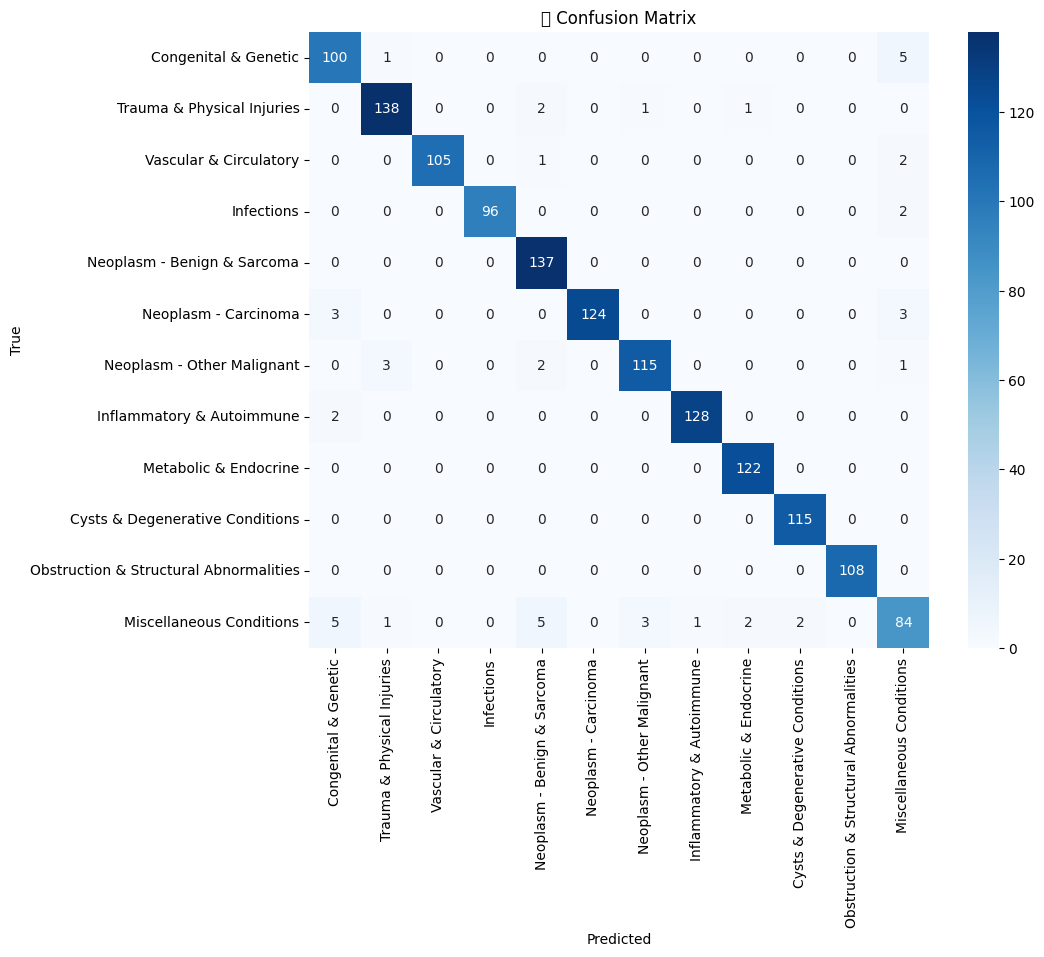


🔬 Sensitivity per class:
Congenital & Genetic: 0.94
Trauma & Physical Injuries: 0.97
Vascular & Circulatory: 0.97
Infections: 0.98
Neoplasm - Benign & Sarcoma: 1.00
Neoplasm - Carcinoma: 0.95
Neoplasm - Other Malignant: 0.95
Inflammatory & Autoimmune: 0.98
Metabolic & Endocrine: 1.00
Cysts & Degenerative Conditions: 1.00
Obstruction & Structural Abnormalities: 1.00
Miscellaneous Conditions: 0.82

🛡️ Specificity per class:
Congenital & Genetic: 0.99
Trauma & Physical Injuries: 1.00
Vascular & Circulatory: 1.00
Infections: 1.00
Neoplasm - Benign & Sarcoma: 0.99
Neoplasm - Carcinoma: 1.00
Neoplasm - Other Malignant: 1.00
Inflammatory & Autoimmune: 1.00
Metabolic & Endocrine: 1.00
Cysts & Degenerative Conditions: 1.00
Obstruction & Structural Abnormalities: 1.00
Miscellaneous Conditions: 0.99


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


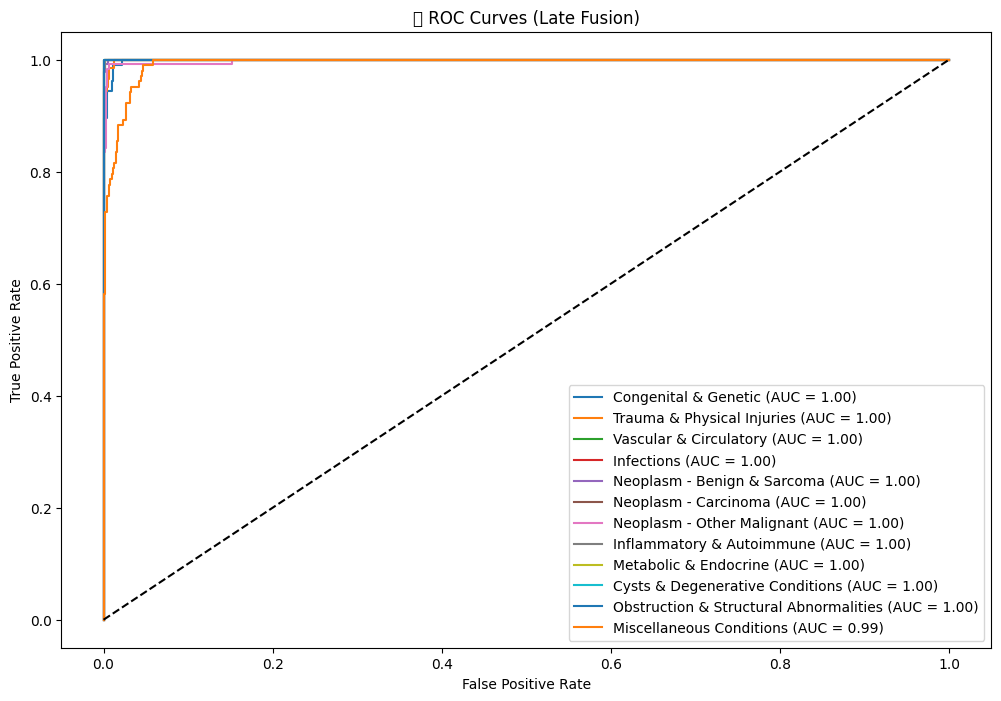

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

final_preds = np.argmax(final_probs, axis=1)

accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds, average='macro')
f1 = f1_score(y_test, final_preds, average='macro')

print(f"\n✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision (macro): {precision:.4f}")
print(f"✅ F1-score (macro): {f1:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, final_preds, target_names=label_mapping.keys()))

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🧩 Confusion Matrix")
plt.show()

sensitivities = []
specificities = []
num_classes = len(label_mapping)

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP

    sensitivity = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0
    sensitivities.append(sensitivity)
    specificities.append(specificity)

print("\n🔬 Sensitivity per class:")
for i, label in enumerate(label_mapping.keys()):
    print(f"{label}: {sensitivities[i]:.2f}")

print("\n🛡️ Specificity per class:")
for i, label in enumerate(label_mapping.keys()):
    print(f"{label}: {specificities[i]:.2f}")

y_test_bin = label_binarize(y_test, classes=list(range(len(label_mapping))))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(label_mapping.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('📈 ROC Curves (Late Fusion)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
